# Energy loss calculation with CRPropa3 

Based on this example for 1D simulation: https://crpropa.github.io/CRPropa3/pages/example_notebooks/sim1D/sim1D.v4.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
import h5py, os

from crpropa import *

## Testbench

Simulation setup

In [2]:
sim = ModuleList()
sim.add( SimplePropagation(1*kpc, 50*kpc) )
sim.add( Redshift() )
sim.add( PhotoPionProduction(CMB()) )
sim.add( PhotoPionProduction(IRB_Kneiske04()) )
sim.add( PhotoDisintegration(CMB()) )
sim.add( PhotoDisintegration(IRB_Kneiske04()) )
sim.add( NuclearDecay() )
sim.add( ElectronPairProduction(CMB()) )
sim.add( ElectronPairProduction(IRB_Kneiske04()) )
sim.add( MinimumEnergy( 0.1 * EeV) )

Observer and output

In [3]:
obs = Observer()
obs.add( ObserverPoint() )
output = TextOutput('output/crpropa_events.txt', Output.Event1D)
obs.onDetection( output )
sim.add( obs )

Source

In [4]:
source = Source()
source.add( SourcePosition(2 * Mpc) )
source.add( SourceRedshift1D() )

#particle_type = nucleusId(1, 1) # proton
particle_type = nucleusId(28, 14) # N-14

source.add( SourceEnergy(80 * EeV) )
source.add( SourceParticleType(particle_type) ) 

Run simulation

In [5]:
N = 10_000
sim.setShowProgress(True)
sim.run(source, N, True)
output.close()

crpropa::ModuleList: Number of Threads: 56
Run ModuleList
  Started Thu Sep 15 11:24:32 2022 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Thu Sep 15 11:24:32 2022


Analyse results

In [6]:
output.close()
sim_data = np.genfromtxt('output/crpropa_events.txt', names=True)

In [7]:
# Observed quantities
Z = np.array([chargeNumber(int(id)) for id in sim_data['ID'].astype(int)])  # element
Z0 = np.array([chargeNumber(int(id)) for id in sim_data['ID0'].astype(int)])
A = np.array([massNumber(int(id)) for id in sim_data['ID'].astype(int)])  # atomic mass number
A0 = np.array([massNumber(int(id)) for id in sim_data['ID0'].astype(int)])
log10E = np.log10(sim_data['E']) + 18  # energy in log10(E/eV))
log10E0 = np.log10(sim_data['E0']) + 18  # energy in log10(E/eV))
E = 10**log10E
E0 = 10**log10E0

In [8]:
# How many final particles per source particles
Nout = len(Z)

Nout / N

1.1456

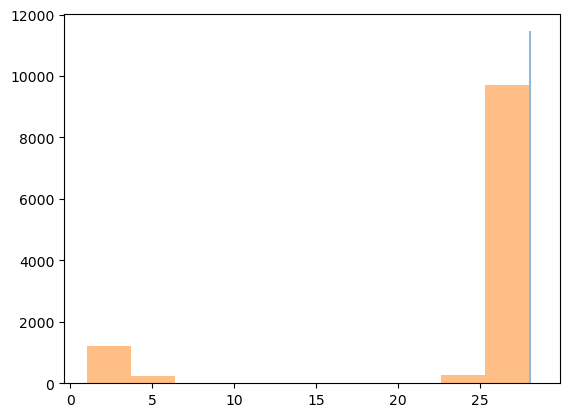

In [9]:
# How much N-14 left at end?
fig, ax = plt.subplots()
ax.hist(A0, alpha=0.5, label="Mass number (source)");
ax.hist(A, alpha=0.5, label="Mass number (arrival)");


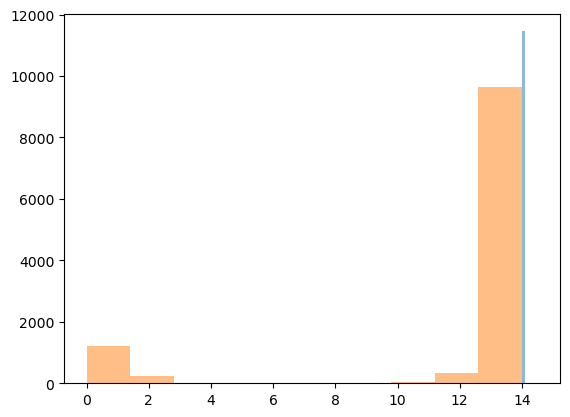

In [10]:
fig, ax = plt.subplots()
ax.hist(Z0, alpha=0.5, label="Charge (source)");
ax.hist(Z, alpha=0.5, label="Charge (arrival)");

In [11]:
nitrogen_mask = (A==14) & (Z==7)
len(A[nitrogen_mask]) / N

0.0

In [12]:
Emin = 0.1 * u.EeV
Emax = 1e5 * u.EeV
E_range = 10**np.linspace(np.log10(Emin.to_value(u.eV)), np.log10(Emax.to_value(u.eV)))

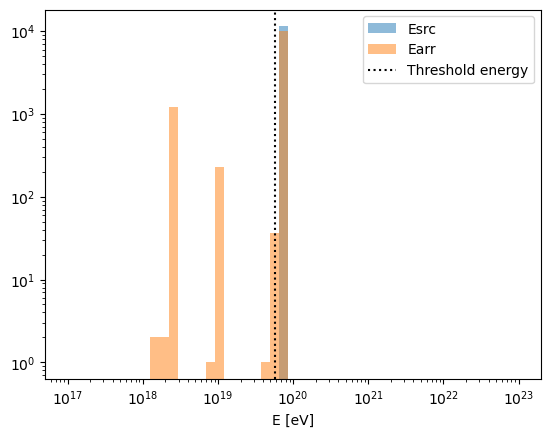

In [13]:
fig, ax = plt.subplots()
ax.hist(E0, bins=E_range, alpha=0.5, label="Esrc")
ax.hist(E, bins=E_range, alpha=0.5, label="Earr")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("E [eV]")
ax.axvline(57e18, color="k", label="Threshold energy", linestyle=":")
ax.legend()

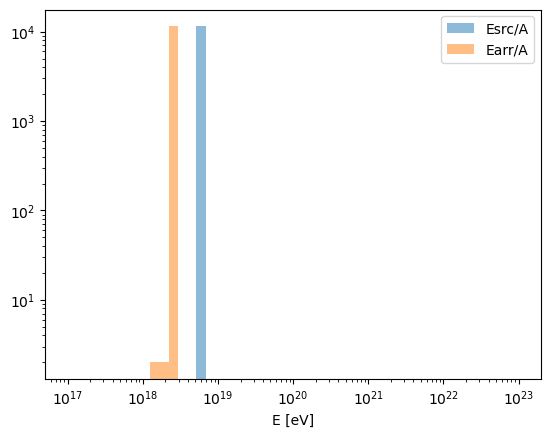

In [14]:
# Source and arrival energies
fig, ax = plt.subplots()
ax.hist(E0/14, bins=E_range, alpha=0.5, label="Esrc/A")
ax.hist(E/A, bins=E_range, alpha=0.5, label="Earr/A")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("E [eV]")
ax.legend()

## Energy losses over grid

In [18]:
N_grid = 50
Esrc_range = 10**np.linspace(1, 4, N_grid) * u.EeV
D_range = 10**np.linspace(0, np.log10(250), N_grid) * u.Mpc
Eth = 57 * u.EeV
N_sim = 1_000
sim_file_name = "output/crpropa_events_grid.txt"

nitrogen_fraction = np.zeros((N_grid, N_grid))
source_particle_fraction = np.zeros((N_grid, N_grid))
mean_arrival_energy = np.zeros((N_grid, N_grid))
mean_arrival_energy_maxA = np.zeros((N_grid, N_grid))
mean_arrival_energy_mcA = np.zeros((N_grid, N_grid))
fraction_above_Eth = np.zeros((N_grid, N_grid))
mean_mass_number = np.zeros((N_grid, N_grid))
mean_energy_per_nucleon = np.zeros((N_grid, N_grid))

E_arr = []
for i, Esrc in enumerate(Esrc_range):
    for j, D in enumerate(D_range):
        
        sim = ModuleList()
        sim.add( SimplePropagation(1*kpc, min([D.to_value(u.Mpc)/10, 10]) * Mpc) )
        sim.add( Redshift() )
        sim.add( PhotoPionProduction(CMB()) )
        sim.add( PhotoPionProduction(IRB_Kneiske04()) )
        sim.add( PhotoDisintegration(CMB()) )
        sim.add( PhotoDisintegration(IRB_Kneiske04()) )
        sim.add( NuclearDecay() )
        sim.add( ElectronPairProduction(CMB()) )
        sim.add( ElectronPairProduction(IRB_Kneiske04()) )
        sim.add( MinimumEnergy( 1 * EeV) )

        obs = Observer()
        obs.add( ObserverPoint() )
        output = TextOutput(sim_file_name, Output.Event1D)
        obs.onDetection( output )
        sim.add( obs )

        source = Source()
        source.add( SourcePosition(D.to_value(u.Mpc) * Mpc) )
        source.add( SourceRedshift1D() )
        particle_type = nucleusId(14, 7) 
        source.add( SourceEnergy(Esrc.to_value(u.EeV) * EeV) )
        source.add( SourceParticleType(particle_type) ) 

        sim.setShowProgress(False)
        sim.run(source, N_sim, True)
        output.close()

        output.close()
        sim_data = np.genfromtxt(sim_file_name, names=True)

        Z = np.array([chargeNumber(int(id)) for id in sim_data['ID'].astype(int)])  
        A = np.array([massNumber(int(id)) for id in sim_data['ID'].astype(int)])  
        E = 10**(np.log10(sim_data['E']) + 18)

        idx_max_A = A[A==max(A)]
        A_list = list(A)
        A_mc = max(set(A_list), key=A_list.count)
        idx_mc_A = A[A==A_mc]
        

        nitrogen_fraction[i][j] = len(A[(A==14) & (Z == 7)]) / N_sim
        source_particle_fraction[i][j] = N_sim / len(A)
        mean_arrival_energy[i][j] = np.mean(E)
        mean_arrival_energy_maxA[i][j] = np.mean(E[idx_max_A])
        mean_arrival_energy_mcA[i][j] = np.mean(E[idx_mc_A])
        fraction_above_Eth[i][j] = len(E[E>Eth.to_value(u.eV)]) / len(E)

        mean_mass_number[i][j] = np.mean(A)
        mean_energy_per_nucleon[i][j] = np.mean(E/A)

        os.remove(sim_file_name)

crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::ModuleList: Number of Threads: 56
crpropa::Mo

In [19]:
# Save
with h5py.File("output/nitrogen_propa_results.h5", "w") as f:
    f.create_dataset("Esrc_range", data=Esrc_range.to_value(u.EeV))
    f.create_dataset("D_range", data=D_range.to_value(u.Mpc))
    f.create_dataset("Eth", data=Eth.to_value(u.EeV))
    f.create_dataset("nitrogen_fraction", data=nitrogen_fraction)
    f.create_dataset("source_particle_fraction", data=source_particle_fraction)
    f.create_dataset("mean_arrival_energy", data=mean_arrival_energy)
    f.create_dataset("mean_arrival_energy_maxA", data=mean_arrival_energy_maxA)
    f.create_dataset("mean_arrival_energy_mcA", data=mean_arrival_energy_mcA)
    f.create_dataset("fraction_above_Eth", data=fraction_above_Eth)
    f.create_dataset("mean_mass_number", data=mean_mass_number)
    f.create_dataset("mean_energy_per_nucleon", data=mean_energy_per_nucleon)

In [3]:
# Load
with h5py.File("output/nitrogen_propa_results.h5", "r") as f:
    Esrc_range = f["Esrc_range"][()] * u.EeV
    D_range = f["D_range"][()] * u.Mpc
    Eth = f["Eth"][()] * u.EeV
    nitrogen_fraction = f["nitrogen_fraction"][()]
    source_particle_fraction = f["source_particle_fraction"][()]
    mean_arrival_energy = f["mean_arrival_energy"][()] * u.eV
    mean_arrival_energy_maxA = f["mean_arrival_energy_maxA"][()] * u.eV
    mean_arrival_energy_mcA = f["mean_arrival_energy_mcA"][()] * u.eV
    fraction_above_Eth = f["fraction_above_Eth"][()]
    mean_mass_number = f["mean_mass_number"][()]
    mean_energy_per_nucleon = f["mean_energy_per_nucleon"][()] * u.eV

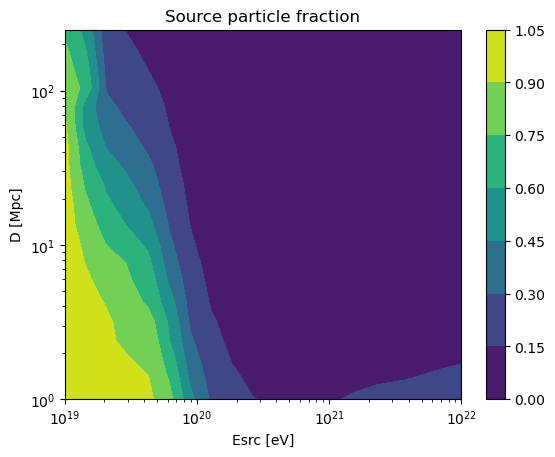

In [8]:
fig, ax = plt.subplots()
h = ax.contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), source_particle_fraction.T)
ax.set_xlabel("Esrc [eV]")
ax.set_ylabel("D [Mpc]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Source particle fraction")
fig.colorbar(h)

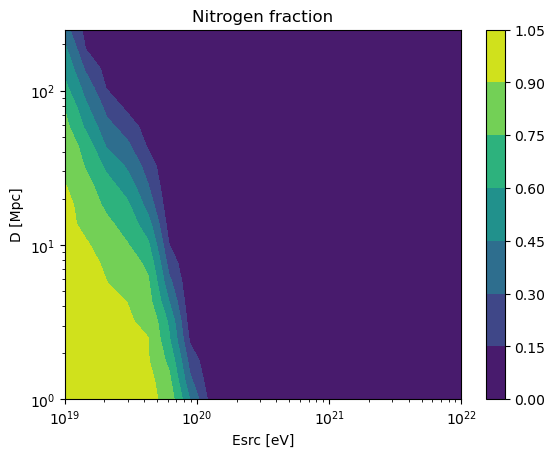

In [9]:
fig, ax = plt.subplots()
h = ax.contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), nitrogen_fraction.T)
ax.set_xlabel("Esrc [eV]")
ax.set_ylabel("D [Mpc]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Nitrogen fraction")
fig.colorbar(h)
fig.savefig("figures/nitrogen_fraction.pdf")

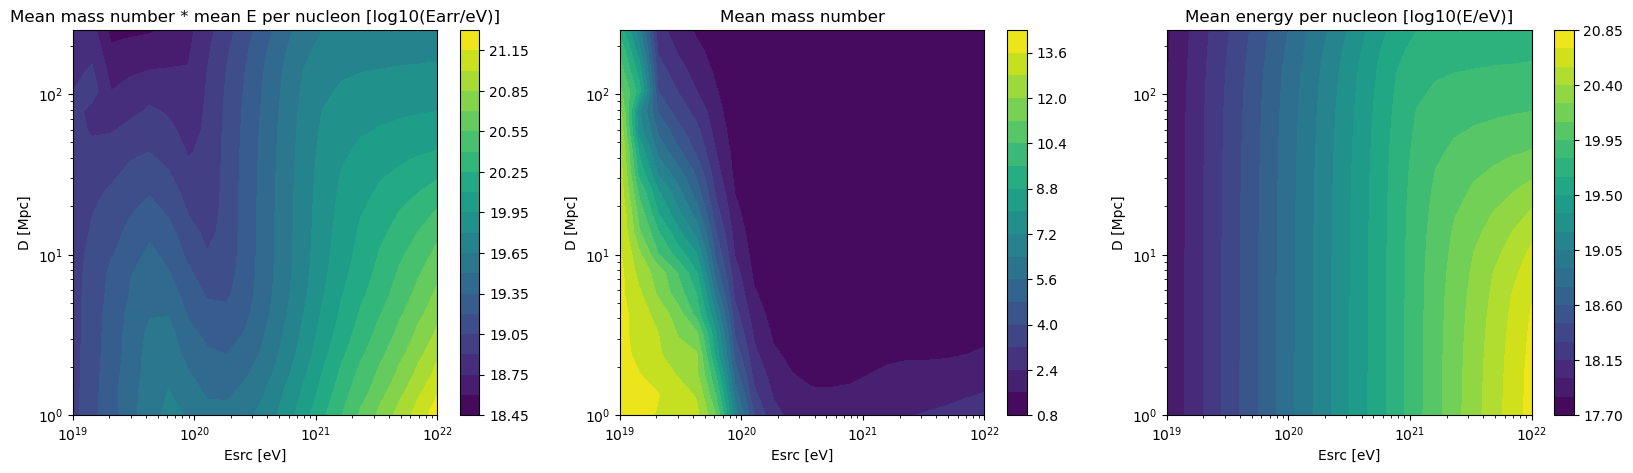

In [10]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 5)

our_approx = mean_mass_number *  mean_energy_per_nucleon.to_value(u.eV)

h0 = ax[0].contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), np.log10(our_approx).T, levels=20)
fig.colorbar(h0, ax=ax[0])
ax[0].set_title("Mean mass number * mean E per nucleon [log10(Earr/eV)]")

h1 = ax[1].contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), mean_mass_number.T, levels=20)
fig.colorbar(h1, ax=ax[1])
ax[1].set_title("Mean mass number")

h2 = ax[2].contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), np.log10(mean_energy_per_nucleon.to_value(u.eV)).T, levels=20)
fig.colorbar(h2, ax=ax[2])
ax[2].set_title("Mean energy per nucleon [log10(E/eV)]")

for axis in ax:
    axis.set_xlabel("Esrc [eV]")
    axis.set_ylabel("D [Mpc]")
    axis.set_xscale("log")
    axis.set_yscale("log")

fig.savefig("figures/new_approx_idea.pdf")

In [ ]:
Esrc_range = Esrc_range.to_value(u.EeV)
Earr_range = our_approx.T / 1e18 # EeV



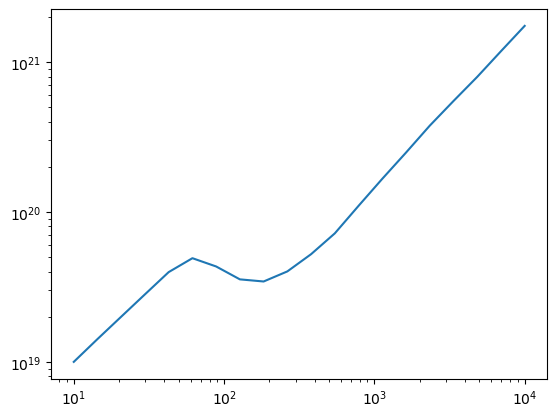

In [15]:




fig, ax = plt.subplots()
ax.plot(Esrc_range.to_value(u.EeV), Earr_range)
ax.set_xscale("log")
ax.set_yscale("log")

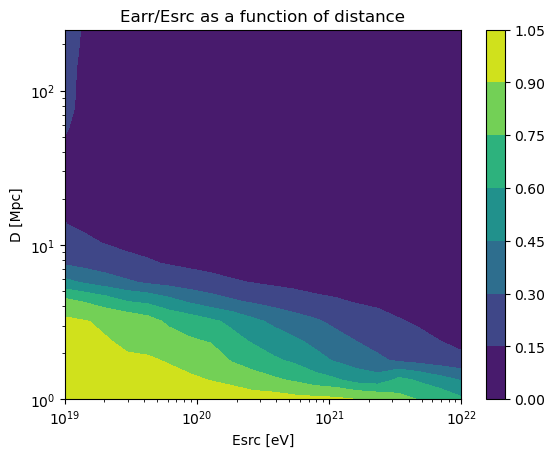

In [35]:
our_approx_scaled = np.array([_/Esrc_range.to_value(u.eV) for _ in our_approx.T])

fig, ax = plt.subplots()
h = ax.contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), our_approx_scaled.T)
ax.set_xlabel("Esrc [eV]")
ax.set_ylabel("D [Mpc]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Earr/Esrc as a function of distance")
fig.colorbar(h)
fig.savefig("figures/relative_energy_fraction.pdf")

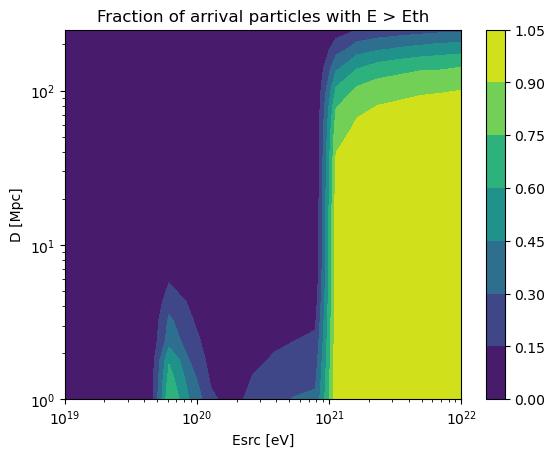

In [24]:
fig, ax = plt.subplots()
h = ax.contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), fraction_above_Eth.T)
ax.set_xlabel("Esrc [eV]")
ax.set_ylabel("D [Mpc]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Fraction of arrival particles with E > Eth")
fig.colorbar(h)

## Loss length

In [33]:
N_grid = 100
Esrc_range = 10**np.linspace(0, 4, N_grid) * u.EeV
D_range = 10**np.linspace(0, np.log10(250), N_grid) * u.Mpc

# Convert to gamma
c = 3e8 * u.m / u.s
m = 14 * 938 * u.MeV / c**2
gamma_range = (Esrc_range / (m * c**2)).to_value(u.dimensionless_unscaled)

In [34]:
photo_pion_cmb = PhotoPionProduction(CMB()) 
photo_pion_irb = PhotoPionProduction(IRB_Kneiske04())
photo_dis_cmb = PhotoDisintegration(CMB()) 
photo_dis_irb = PhotoDisintegration(IRB_Kneiske04())
nuc_decay = NuclearDecay() 
pair_prod_cmb = ElectronPairProduction(CMB())
pair_prod_irb = ElectronPairProduction(IRB_Kneiske04()) 

In [35]:
ll_photo_pion_cmb = [photo_pion_cmb.lossLength(nucleusId(14, 7), g, 0.0) for g in gamma_range] * u.m
ll_photo_pion_irb = [photo_pion_irb.lossLength(nucleusId(14, 7), g, 0.0) for g in gamma_range] * u.m
ll_photo_dis_cmb = [photo_dis_cmb.lossLength(nucleusId(14, 7), g, 0.0) for g in gamma_range] * u.m
ll_photo_dis_irb = [photo_dis_irb.lossLength(nucleusId(14, 7), g, 0.0) for g in gamma_range] * u.m
ll_pair_prod_cmb = [pair_prod_cmb.lossLength(nucleusId(14, 7), g, 0.0) for g in gamma_range] * u.m
ll_pair_prod_irb = [pair_prod_irb.lossLength(nucleusId(14, 7), g, 0.0) for g in gamma_range] * u.m
ll_adiabatic = [(4000*u.Mpc).to_value(u.m) for g in gamma_range] * u.m
ll_total = 1/(1/ll_photo_pion_cmb + 1/ll_photo_pion_irb + 1/ll_photo_dis_cmb 
    + 1/ll_photo_dis_irb + 1/ll_pair_prod_cmb + 1/ll_pair_prod_irb + 1/ll_adiabatic)

Reproduce Fig from Batista et al. 2015. 

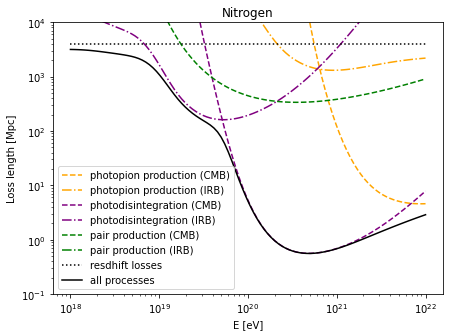

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
ax.plot(Esrc_range.to_value(u.eV), ll_photo_pion_cmb.to_value(u.Mpc), color="orange", linestyle="--", label="photopion production (CMB)")
ax.plot(Esrc_range.to_value(u.eV), ll_photo_pion_irb.to_value(u.Mpc), color="orange", linestyle="-.", label="photopion production (IRB)")
ax.plot(Esrc_range.to_value(u.eV), ll_photo_dis_cmb.to_value(u.Mpc), color="purple", linestyle="--", label="photodisintegration (CMB)")
ax.plot(Esrc_range.to_value(u.eV), ll_photo_dis_irb.to_value(u.Mpc), color="purple", linestyle="-.", label="photodisintegration (IRB)")
ax.plot(Esrc_range.to_value(u.eV), ll_pair_prod_cmb.to_value(u.Mpc), color="green", linestyle="--", label="pair production (CMB)")
ax.plot(Esrc_range.to_value(u.eV), ll_pair_prod_irb.to_value(u.Mpc), color="green", linestyle="-.", label="pair production (IRB)")
ax.plot(Esrc_range.to_value(u.eV), ll_adiabatic.to_value(u.Mpc), color="black", linestyle=":", label="resdhift losses")
ax.plot(Esrc_range.to_value(u.eV), ll_total.to_value(u.Mpc), color="black", linestyle="-", label="all processes")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.1, 1e4)
ax.set_xlabel("E [eV]")
ax.set_ylabel("Loss length [Mpc]")
ax.legend()
ax.set_title("Nitrogen")
fig.savefig("figures/nitrogen_loss_length.pdf")


In [37]:
from scipy import integrate

In [24]:
H0 = 70 * u.km / (u.s * u.Mpc)
DH = (c / H0).to(u.Mpc)

def get_ll_total(nucleus_id, gamma, z):
    ll_photo_pion_cmb = photo_pion_cmb.lossLength(nucleus_id, gamma, z) * u.m
    ll_photo_pion_irb = photo_pion_irb.lossLength(nucleus_id, gamma, z) * u.m
    ll_photo_dis_cmb = photo_dis_cmb.lossLength(nucleus_id, gamma, z) * u.m
    ll_photo_dis_irb = photo_dis_irb.lossLength(nucleus_id, gamma, z) * u.m
    ll_pair_prod_cmb = pair_prod_cmb.lossLength(nucleus_id, gamma, z) * u.m
    ll_pair_prod_irb = pair_prod_irb.lossLength(nucleus_id, gamma, z) * u.m
    ll_adiabatic = DH.to(u.m)
    ll_total = 1/(1/ll_photo_pion_cmb + 1/ll_photo_pion_irb + 1/ll_photo_dis_cmb 
        + 1/ll_photo_dis_irb + 1/ll_pair_prod_cmb + 1/ll_pair_prod_irb + 1/ll_adiabatic)

    return ll_total.to_value(u.Mpc)

def dEdr(r, E):
    z = r / DH.to_value(u.Mpc)
    gamma = ((E * u. eV) / (m * c**2)).to_value(u.dimensionless_unscaled)[0]
    ll_total = get_ll_total(nucleusId(14, 7), gamma, z)

    return - E / ll_total    

In [159]:
N_grid = 20
Esrc_range = 10**np.linspace(0, 4, N_grid) * u.EeV
D_range = 10**np.linspace(0, np.log10(250), N_grid) * u.Mpc

arrival_energies = np.zeros((N_grid, N_grid))
for i, Esrc in enumerate(Esrc_range):
    for j, D in enumerate(D_range):

        integrator = integrate.ode(dEdr).set_integrator("lsoda", method="bdf")
        dr = min([D.to_value(u.Mpc)/10, 10]) * u.Mpc
        integrator.set_initial_value(Esrc.to_value(u.eV), 0.0)

        while integrator.successful() and integrator.t < D.to_value(u.Mpc):
            integrator.integrate(integrator.t + dr.to_value(u.Mpc))

        arrival_energies[i][j] = integrator.y # eV

In [160]:
with h5py.File("output/nitrogen_loss_length_results.h5", "w") as f:
    f.create_dataset("Esrc_range", data=Esrc_range.to_value(u.EeV))
    f.create_dataset("D_range", data=D_range.to_value(u.Mpc))
    f.create_dataset("arrival_energies", data=arrival_energies)

In [38]:
with h5py.File("output/nitrogen_loss_length_results.h5", "r") as f:
    Esrc_range = f["Esrc_range"][()] * u.EeV
    D_range = f["D_range"][()] * u.Mpc
    arrival_energies = f["arrival_energies"][()] * u.eV

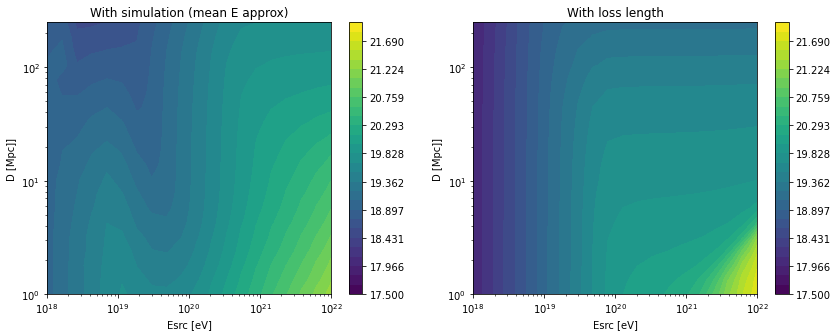

In [39]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 5)

levels = np.linspace(17.5, 22, 30)

h0 = ax[0].contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), np.log10(mean_arrival_energy.to_value(u.eV)).T, levels=levels)
ax[0].set_title("With simulation (mean E approx)")

h1 = ax[1].contourf(Esrc_range.to_value(u.eV), D_range.to_value(u.Mpc), np.log10(arrival_energies.to_value(u.eV)).T, levels=levels)
ax[1].set_title("With loss length")

for axis in ax:
    axis.set_xscale("log")
    axis.set_yscale("log")
    axis.set_xlabel("Esrc [eV]")
    axis.set_ylabel("D [Mpc]]")

fig.colorbar(h0, ax=ax[0])
fig.colorbar(h1, ax=ax[1])
fig.savefig("figures/simulation_vs_losslength.pdf")

Test interpolation


In [8]:
with h5py.File("output/test_crpropa_table_file.h5", "r") as f:
    Esrc_grid = f["Esrc_grid"][()] # EeV
    D_grid = f["D_grid"][()] # Mpc
    mean_mass_number = f["mean_mass_number"][()]
    mean_energy_per_nucleon = f["mean_energy_per_nucleon"][()] # EeV

mean_energy = mean_mass_number * mean_energy_per_nucleon


In [34]:
from scipy import interpolate

interp_func = interpolate.interp2d(np.log10(Esrc_grid), np.log10(D_grid), np.log10(mean_energy).T)

new_Esrc_grid = 10**np.linspace(1, 4)
new_D_grid = 10**np.linspace(np.log10(1), np.log10(250), 30)
test_interp = np.zeros((50, 30))
for i, E in enumerate(new_Esrc_grid):
    for j, D in enumerate(new_D_grid):
        test_interp[i][j] = 10**interp_func(np.log10(E), np.log10(D))

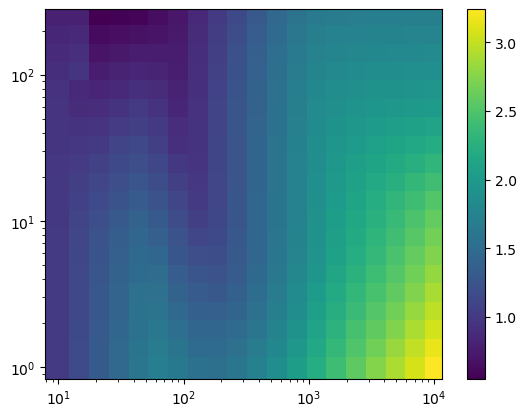

In [35]:
fig, ax = plt.subplots()
h = ax.pcolormesh(Esrc_grid, D_grid, np.log10(mean_energy).T)
ax.set_xscale("log")
ax.set_yscale("log")
fig.colorbar(h)

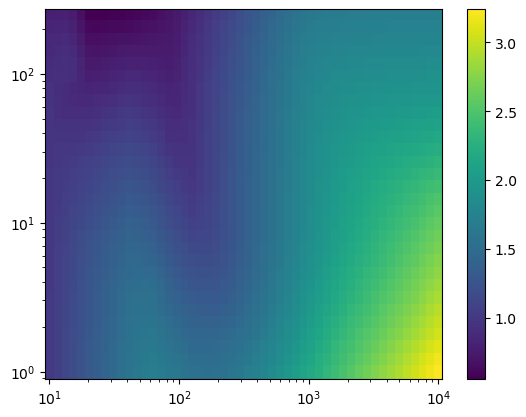

In [36]:
fig, ax = plt.subplots()
h= ax.pcolormesh(new_Esrc_grid, new_D_grid, np.log10(test_interp).T)
ax.set_xscale("log")
ax.set_yscale("log")
fig.colorbar(h)

## Save tables for fancy

In [14]:
import h5py
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt

In [15]:
with h5py.File("output/crpropa_sim_table_Si.h5", "r") as f:
    Esrc_grid = f["Esrc_range"][()] * u.EeV
    D_grid  = f["D_range"][()] * u.Mpc
    mean_mass_number = f["mean_mass_number"][()]
    mean_energy_per_nucleon = f["mean_energy_per_nucleon"][()] * u.eV
mean_energy = mean_mass_number * mean_energy_per_nucleon

In [16]:
with h5py.File("output/crpropa_mean_energy_Si.h5", "w") as f:
    f.create_dataset("Esrc_grid", data=Esrc_grid.to_value(u.EeV))
    f.create_dataset("D_grid", data=D_grid.to_value(u.Mpc))
    f.create_dataset("mean_mass_number", data=mean_mass_number)
    f.create_dataset("mean_energy_per_nucleon", data=mean_energy_per_nucleon.to_value(u.EeV))

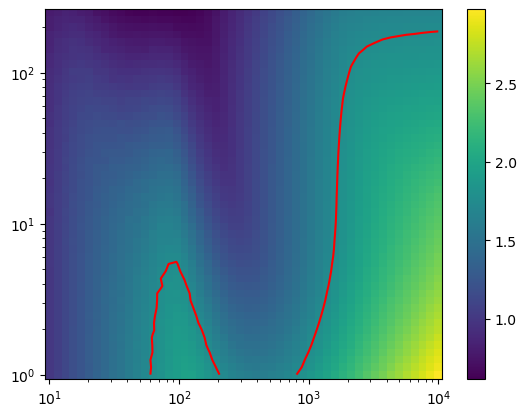

In [17]:
fig, ax = plt.subplots()
h = ax.pcolormesh(Esrc_grid.to_value(u.EeV), D_grid.to_value(u.Mpc), np.log10(mean_energy.to_value(u.EeV)).T)
ax.contour(Esrc_grid.to_value(u.EeV), D_grid.to_value(u.Mpc), np.log10(mean_energy.to_value(u.EeV)).T, [np.log10(57)], colors="red")
ax.set_xscale("log")
ax.set_yscale("log")
fig.colorbar(h)